### Library Import

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../..")

from src.sanity import *

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

### Load dataset 

In [3]:
from src.load_datasets import load_air_quality_data


def replace_200(dataframe):
    dataframe.replace(-200, np.nan, inplace=True)
    return dataframe


def drp_col(dataframe):
    dataframe.drop(columns=["NMHC_true"], inplace=True)
    return dataframe


dataframe = (
    load_air_quality_data()
    .pipe(format_datetime, col="Date_Time")
    .pipe(set_index, col="Date_Time")
    .pipe(replace_200)
    .pipe(drp_col)
    .pipe(replace_null)
    # .pipe(interpolate_column, cols="pollution")
    .pipe(resample_data, freq="H")
)

print(f"dataframe shape {dataframe.shape}")

# dataframe = dataframe.tail(515)

dataframe.head()

dataframe shape (9357, 12)


,CO_true,CO_sensor,C6H6_true,NMHC_sensor,NOX_true,NOX_sensor,NO2_true,NO2_sensor,O3_sensor,T,RH,AH
Date_Time,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [4]:
dataframe.isna().sum()

CO_true        0
CO_sensor      0
C6H6_true      0
NMHC_sensor    0
NOX_true       0
NOX_sensor     0
NO2_true       0
NO2_sensor     0
O3_sensor      0
T              0
RH             0
AH             0
dtype: int64

In [5]:
# dataframe.info()
# dataframe.isna().sum()
corr = dataframe.corr()
corr.style.background_gradient(cmap="coolwarm")

,CO_true,CO_sensor,C6H6_true,NMHC_sensor,NOX_true,NOX_sensor,NO2_true,NO2_sensor,O3_sensor,T,RH,AH
CO_true,1.000000,0.749882,0.786693,0.779185,0.778469,-0.618746,0.660310,0.549938,0.727845,0.040164,0.057730,0.079035
CO_sensor,0.749882,1.000000,0.873365,0.888283,0.635560,-0.777750,0.600477,0.662124,0.902369,0.025554,0.112759,0.104307
C6H6_true,0.786693,0.873365,1.000000,0.981778,0.622739,-0.721795,0.555864,0.745159,0.851389,0.187815,-0.069203,0.147080
NMHC_sensor,0.779185,0.888283,0.981778,1.000000,0.618171,-0.787787,0.588266,0.759808,0.870473,0.227390,-0.094304,0.165582
NOX_true,0.778469,0.635560,0.622739,0.618171,1.000000,-0.599991,0.774805,0.207077,0.690107,-0.236985,0.214948,-0.112785
NOX_sensor,-0.618746,-0.777750,-0.721795,-0.787787,-0.599991,1.000000,-0.603942,-0.527495,-0.796219,-0.121843,-0.064873,-0.209072
NO2_true,0.660310,0.600477,0.555864,0.588266,0.774805,-0.603942,1.000000,0.138934,0.655578,-0.182211,-0.069680,-0.305178
NO2_sensor,0.549938,0.662124,0.745159,0.759808,0.207077,-0.527495,0.138934,1.000000,0.563346,0.558723,-0.034656,0.626252
O3_sensor,0.727845,0.902369,0.851389,0.870473,0.690107,-0.796219,0.655578,0.563346,1.000000,-0.052566,0.122545,0.036286
T,0.040164,0.025554,0.187815,0.227390,-0.236985,-0.121843,-0.182211,0.558723,-0.052566,1.000000,-0.580523,0.658454


### Test Train split

train_xy and test_xy size: (9342, 12), (15, 12)

y_train and x_train size (9342,), (9342, 11)
y_test  and x_test  size (15,),  (15, 11)



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='CO_true'>)

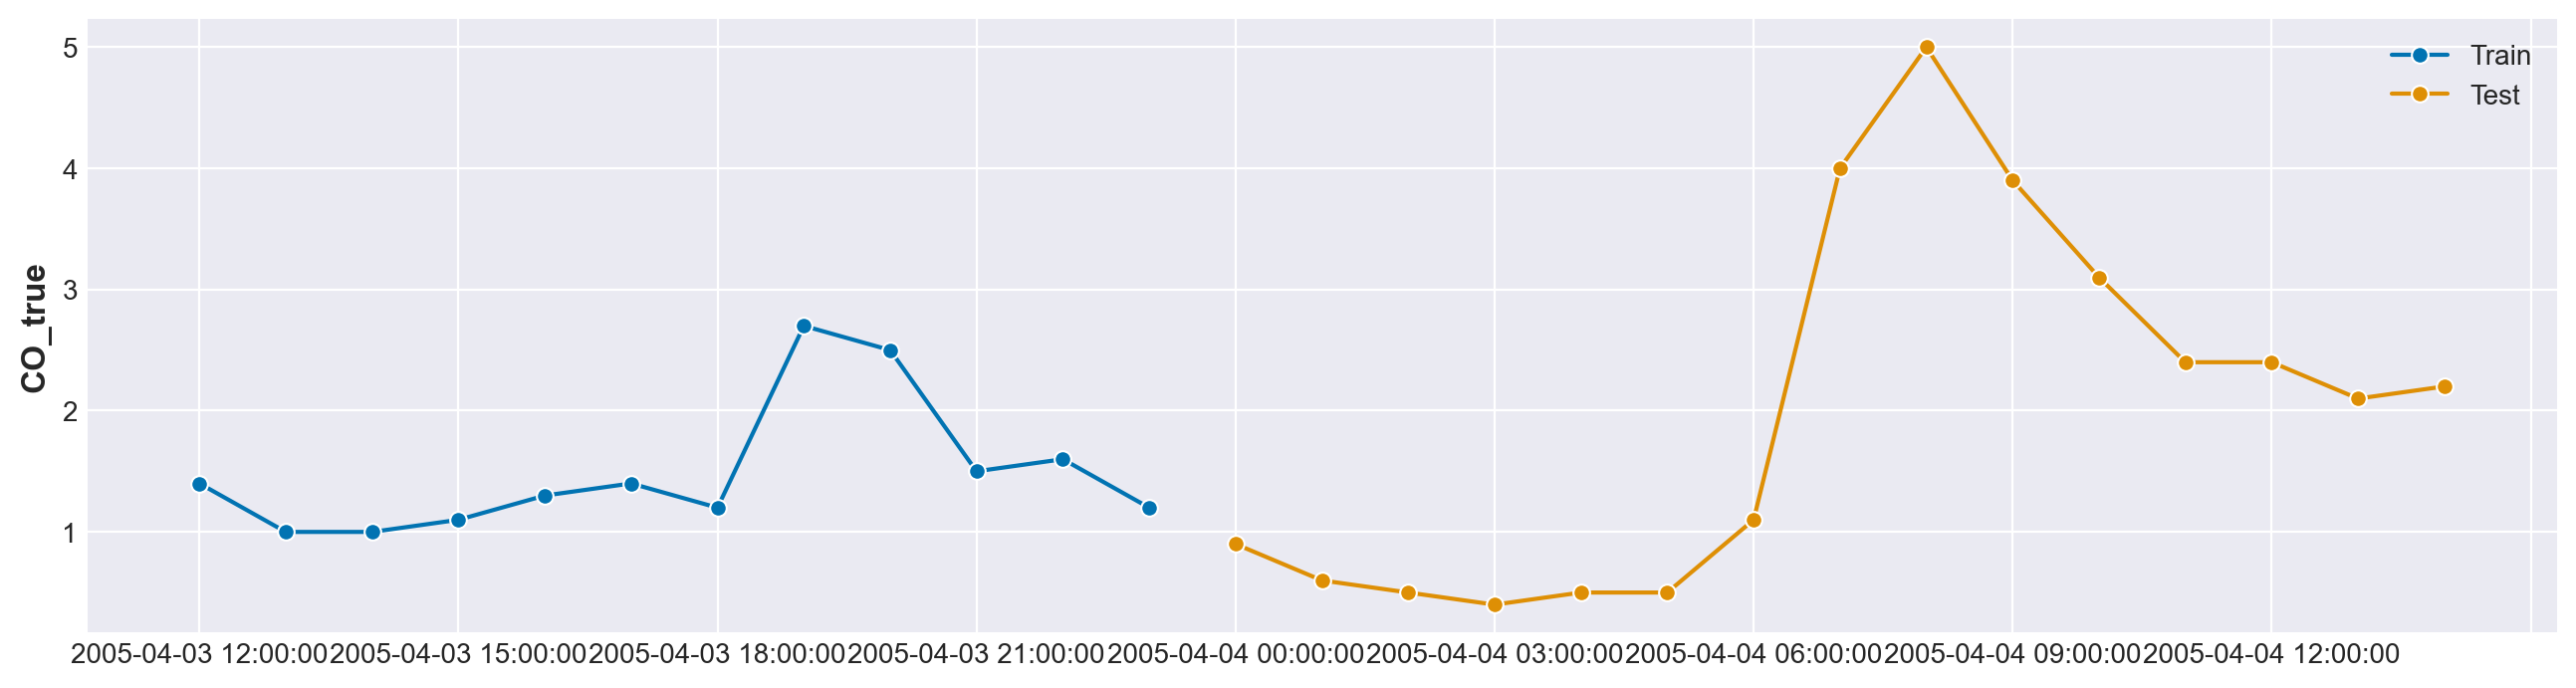

In [6]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

TEST_SIZE = 15
TARGET_COl = "CO_true"

train_xy, test_xy = temporal_train_test_split(dataframe, test_size=TEST_SIZE)

print(f"train_xy and test_xy size: {train_xy.shape}, {test_xy.shape}", end="\n\n")

y_train = train_xy[TARGET_COl].copy(deep=True)
x_train = train_xy.drop(columns=[TARGET_COl]).copy(deep=True)

y_test = test_xy[TARGET_COl].copy(deep=True)
x_test = test_xy.drop(columns=[TARGET_COl]).copy(deep=True)

print(f"y_train and x_train size {y_train.shape}, {x_train.shape}")
print(
    f"y_test  and x_test  size {y_test.shape},  {x_test.shape}",
    end="\n\n",
)

plot_series(y_train.tail(12), y_test, labels=["Train", "Test"])

In [7]:
import warnings
from sktime.transformations.base import BaseTransformer


class ColumnsGuard(BaseTransformer):
    _tags = {
        "scitype:transform-input": "Series",
        # what is the scitype of X: Series, or Panel
        "scitype:transform-output": "Series",
        # what scitype is returned: Primitives, Series, Panel
        "scitype:transform-labels": "None",
        # what is the scitype of y: None (not needed), Primitives, Series, Panel
        "scitype:instancewise": True,  # is this an instance-wise transform?
        "capability:inverse_transform": True,  # can the transformer inverse transform?
        "univariate-only": False,  # can the transformer handle multivariate X?
        "X_inner_mtype": "pd.DataFrame",  # which mtypes do _fit/_predict support for X?
        # this can be a Panel mtype even if transform-input is Series, vectorized
        "y_inner_mtype": "None",  # which mtypes do _fit/_predict support for y?
        "requires_y": False,  # does y need to be passed in fit?
        "enforce_index_type": None,  # index type that needs to be enforced in X/y
        "fit_is_empty": False,  # is fit empty and can be skipped? Yes = True
        "X-y-must-have-same-index": True,  # can estimator handle different X/y index?
        "transform-returns-same-time-index": True,
        # does transform return have the same time index as input X
        "skip-inverse-transform": False,  # is inverse-transform skipped when called?
        "capability:unequal_length": True,
        # can the transformer handle unequal length time series (if passed Panel)?
        "capability:unequal_length:removes": True,
        # is transform result always guaranteed to be equal length (and series)?
        #   not relevant for transformers that return Primitives in transform-output
        "handles-missing-data": False,  # can estimator handle missing data?
        # todo: rename to capability:missing_values
        "capability:missing_values:removes": False,
        # is transform result always guaranteed to contain no missing values?
    }

    def __init__(self):
        super(ColumnsGuard, self).__init__()


    def _fit(self, X, y=None):
        self._columns_name = X.columns.tolist()
        return self

    # todo: implement this, mandatory
    def _transform(self, X, y=None):
        if self._columns_name == X.columns.tolist():
            X_transformed = X.copy(deep=True)
        else:
            missing_col = set(self._columns_name) - set(X.columns.tolist())
            extra_col = set(X.columns.tolist()) - set(self._columns_name)  
            if missing_col:
                raise ValueError('Missing columns: {missing_col}') 
            elif extra_col:
                warnings.warn('Got extra columns: {extra_col}, ignoring')
                X_transformed = X[self.self._columns_name].copy(deep=True)
        return X_transformed  

    def _inverse_transform(self, X, y=None):
        X_inv_transformed = X.copy(deep=True)
        return X_inv_transformed     

    @classmethod
    def get_test_params(cls, parameter_set="default"):
        params = {}
        return params

In [8]:
from sktime.utils.estimator_checks import check_estimator

results = check_estimator(ColumnsGuard, raise_exceptions=True)

All tests PASSED!


#### Huyper Parameter Selection 

intital_window_size 9267 , step_length 15 for fold 5


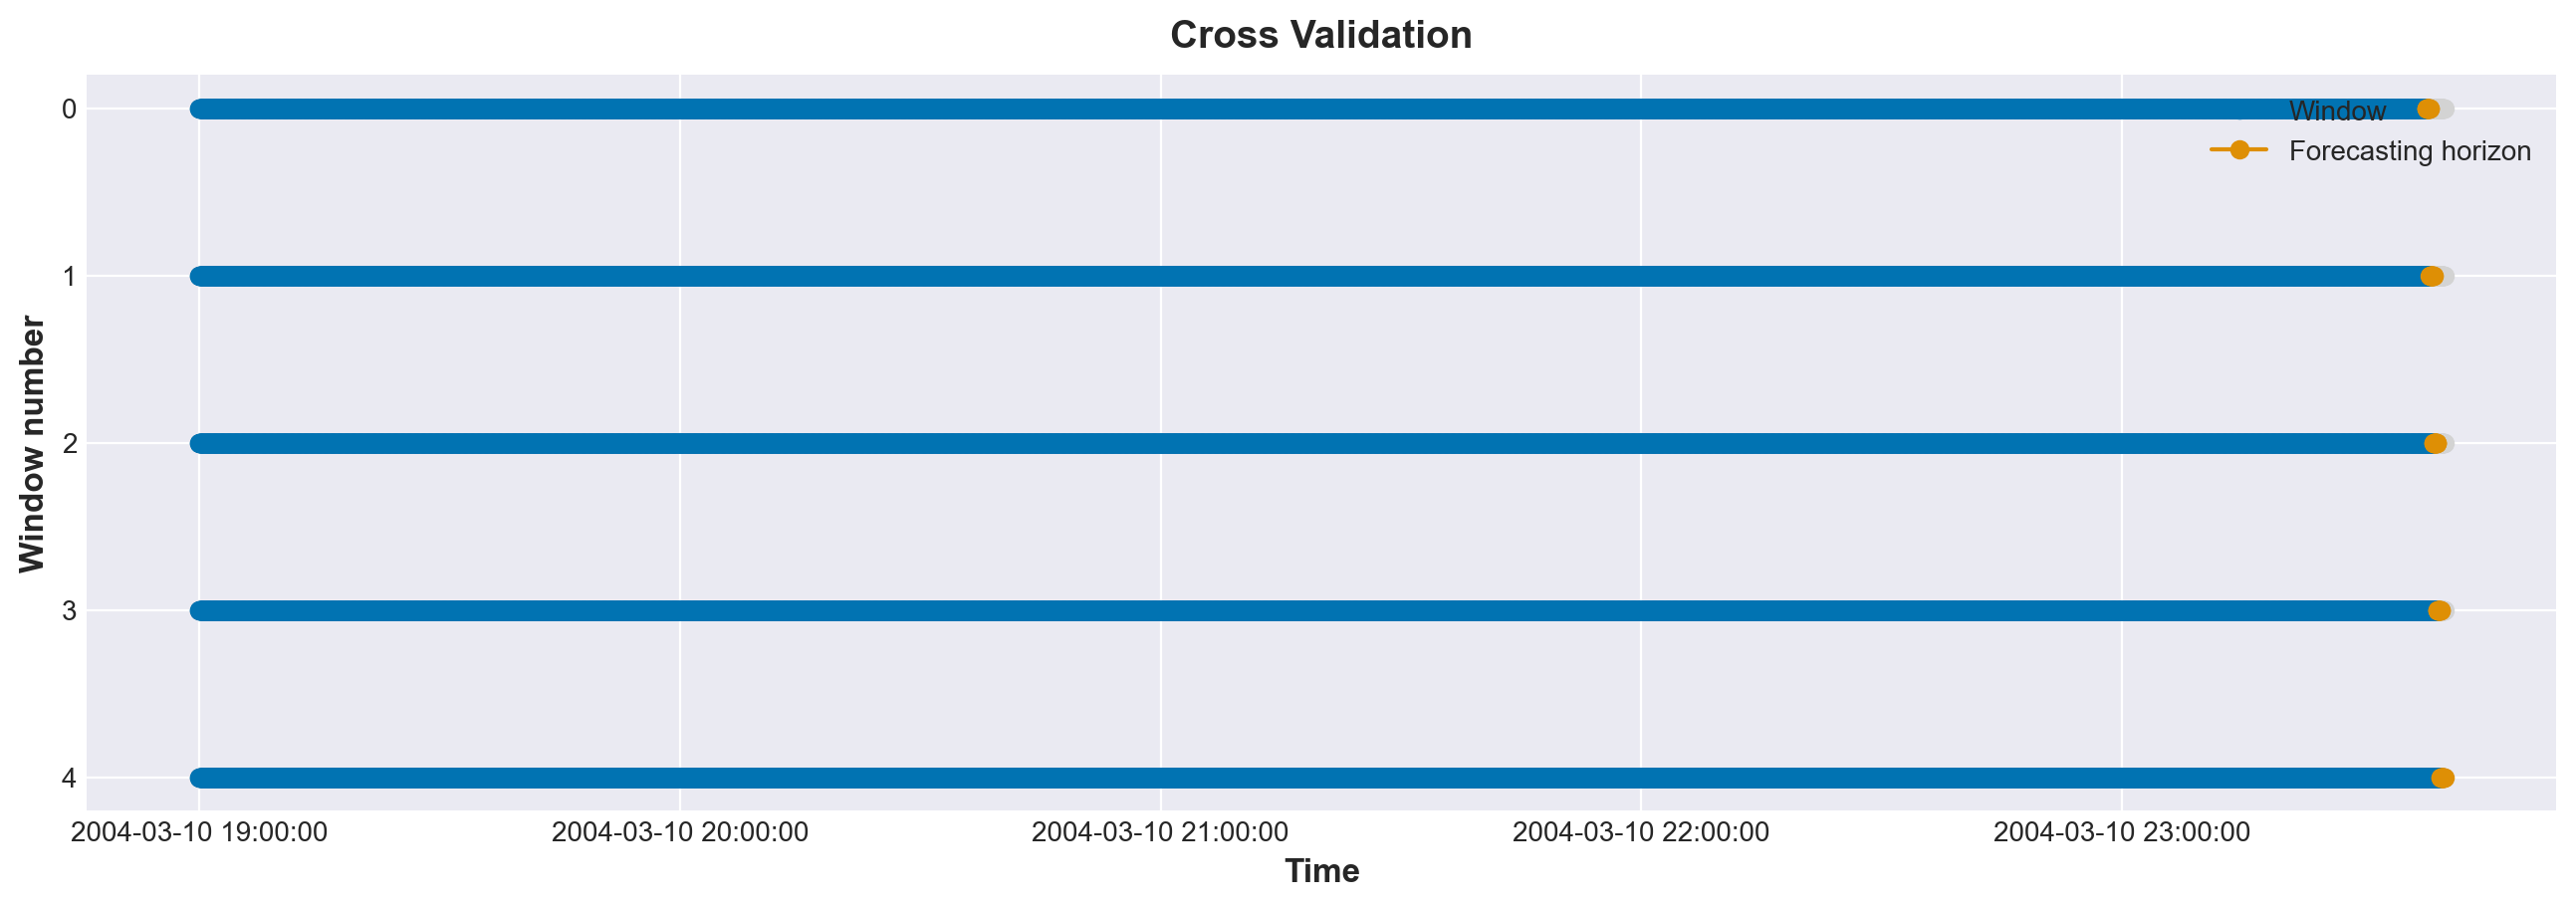

In [9]:
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
)
from sktime.utils.plotting import plot_windows

fh = np.arange(1, TEST_SIZE + 1)

y_size = len(y_train)

fold = 5

step_length = len(fh)

fh_max_length = max(fh)

intital_window_size = y_size - ((fold - 1) * step_length + 1 * fh_max_length)

# intital_window_size = int(y_train.shape[0] * 0.80)

print(
    f"intital_window_size {intital_window_size} , step_length {step_length} for fold {fold}"
)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

plot_windows(cv, y_train, title="Cross Validation")

In [10]:
%%time

from sklearn.preprocessing import MinMaxScaler

try:
    from sklearnex.linear_model import ElasticNet

    print("Importing sklearnex ElasticNet")
except ImportError:
    from sklearn.linear_model import ElasticNet

from sktime.forecasting.compose import (
    ForecastingPipeline,
    make_reduction,
    TransformedTargetForecaster,
)
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.detrend import (
    Detrender,
    Deseasonalizer,
    ConditionalDeseasonalizer,
)
from sktime.forecasting.trend import PolynomialTrendForecaster

from sktime.forecasting.model_selection import ForecastingGridSearchCV,ForecastingRandomizedSearchCV
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

from scipy.stats.distributions import randint,uniform

param_grid = {
    "forecaster__deseasonalizer__model": ["additive", "multiplicative"],
    "forecaster__deseasonalizer__sp": [24],
    "forecaster__detrender__forecaster__degree": [1, 2],
    "forecaster__reducer__window_length": [24],
    "forecaster__reducer__estimator__fit_intercept": [True, False],
    "forecaster__reducer__estimator__alpha": [0.01, 0.1, 1, 10],
    "forecaster__reducer__estimator__l1_ratio": [0.01, 0.1, 0.5, 1.0],
    "forecaster__reducer__estimator__max_iter": [1000],
}

param_dist = {
    "forecaster__deseasonalizer__model": ["additive", "multiplicative"],
    "forecaster__deseasonalizer__sp": [24, 48],
    "forecaster__detrender__forecaster__degree": randint(1, 10),
    "forecaster__reducer__window_length": randint(24, 2 * 24),
    "forecaster__reducer__estimator__alpha": uniform(0, 1),
    "forecaster__reducer__estimator__l1_ratio": uniform(0.01, 0.9999999999),
    "forecaster__reducer__estimator__max_iter": [1000],
    "forecaster__reducer__estimator__fit_intercept": [True, False],
}

forecaster_pipe = ForecastingPipeline(
    steps=[
        ('column_Gaurd', ColumnsGuard()),
        (
            "x_transforner",
            TransformerPipeline(
                steps=[("imputer_x", Imputer(method="ffill", random_state=80))]
            ),
        ),
        ("scaler_x", TabularToSeriesAdaptor(MinMaxScaler())),
        (
            "forecaster",
            TransformedTargetForecaster(
                steps=[
                    ("imputer_y", Imputer(method="ffill", random_state=80)),
                    (
                        "deseasonalizer",
                        ConditionalDeseasonalizer(model="additive", sp=24),
                    ),
                    (
                        "detrender",
                        Detrender(forecaster=PolynomialTrendForecaster(degree=1)),
                    ),
                    (
                        "reducer",
                        make_reduction(
                            estimator=ElasticNet(random_state=80),
                            scitype="tabular-regressor",
                            window_length=10,
                            strategy="recursive",
                            pooling="global",
                        ),
                    ),
                ]
            ),
        ),
    ]
)

fh = np.arange(1, TEST_SIZE + 1)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

print(f"Number of CPU Count:   {os.cpu_count()}")

n_cpu = os.cpu_count() - 1 if os.cpu_count() > 2 else 1

gscv = ForecastingRandomizedSearchCV(
    forecaster_pipe,
    strategy="refit",
    scoring=MeanAbsolutePercentageError(symmetric=True),
    cv=cv,
    param_distributions=param_dist,
    verbose=10,
    n_jobs=n_cpu,
    refit=True,
    error_score="raise",
    n_iter=15
)

gscv.fit(y_train, X=None, fh=fh)

print("Best Params", gscv.best_params_)
print("Best Params", gscv.best_score_)
# print('Best Params', gscv.best_forecaster_)

Number of CPU Count:   12
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Params {'forecaster__deseasonalizer__model': 'multiplicative', 'forecaster__deseasonalizer__sp': 24, 'forecaster__detrender__forecaster__degree': 7, 'forecaster__reducer__estimator__alpha': 0.10590309591477354, 'forecaster__reducer__estimator__fit_intercept': False, 'forecaster__reducer__estimator__l1_ratio': 0.06509849919039908, 'forecaster__reducer__estimator__max_iter': 1000, 'forecaster__reducer__window_length': 30}
Best Params 0.31829920226914077
CPU times: total: 312 ms
Wall time: 13.7 s


In [11]:
gscv.cv_results_

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.588596,0.180950,0.868902,{'forecaster__deseasonalizer__model': 'multipl...,12.0
1,0.381344,0.188177,0.958257,{'forecaster__deseasonalizer__model': 'multipl...,4.0
2,0.593508,0.195657,1.108739,{'forecaster__deseasonalizer__model': 'multipl...,13.0
3,0.318299,0.188770,0.897076,{'forecaster__deseasonalizer__model': 'multipl...,1.0
4,0.479842,0.205224,1.136705,{'forecaster__deseasonalizer__model': 'additiv...,9.0
5,0.408622,0.190055,1.043430,{'forecaster__deseasonalizer__model': 'multipl...,6.0
6,0.474438,0.168274,0.795543,{'forecaster__deseasonalizer__model': 'multipl...,8.0
7,0.491825,0.160953,0.853820,{'forecaster__deseasonalizer__model': 'multipl...,10.0
8,0.512636,0.192065,1.080956,{'forecaster__deseasonalizer__model': 'additiv...,11.0
9,0.473510,0.189613,1.041034,{'forecaster__deseasonalizer__model': 'multipl...,7.0


In [12]:
print(x_test.columns)
#Best Params 0.2063950931289483
#CPU times: total: 672 ms
#Wall time: 4min 55s

Index(['CO_sensor', 'C6H6_true', 'NMHC_sensor', 'NOX_true', 'NOX_sensor',
       'NO2_true', 'NO2_sensor', 'O3_sensor', 'T', 'RH', 'AH'],
      dtype='object')


In [13]:
x_test_tt = x_test.drop(columns=['C6H6_true','O3_sensor'])
y_predict = gscv.predict(fh=fh, X=x_test_tt)

2005-04-04 00:00:00    1.191311
2005-04-04 01:00:00    1.035928
2005-04-04 02:00:00    0.869128
2005-04-04 03:00:00    0.770770
2005-04-04 04:00:00    0.641623
2005-04-04 05:00:00    0.580342
2005-04-04 06:00:00    0.663069
2005-04-04 07:00:00    1.088943
2005-04-04 08:00:00    1.603019
2005-04-04 09:00:00    1.774786
2005-04-04 10:00:00    1.693267
2005-04-04 11:00:00    1.587515
2005-04-04 12:00:00    1.530566
2005-04-04 13:00:00    1.478764
2005-04-04 14:00:00    1.392945
Freq: H, Name: CO_true, dtype: float64

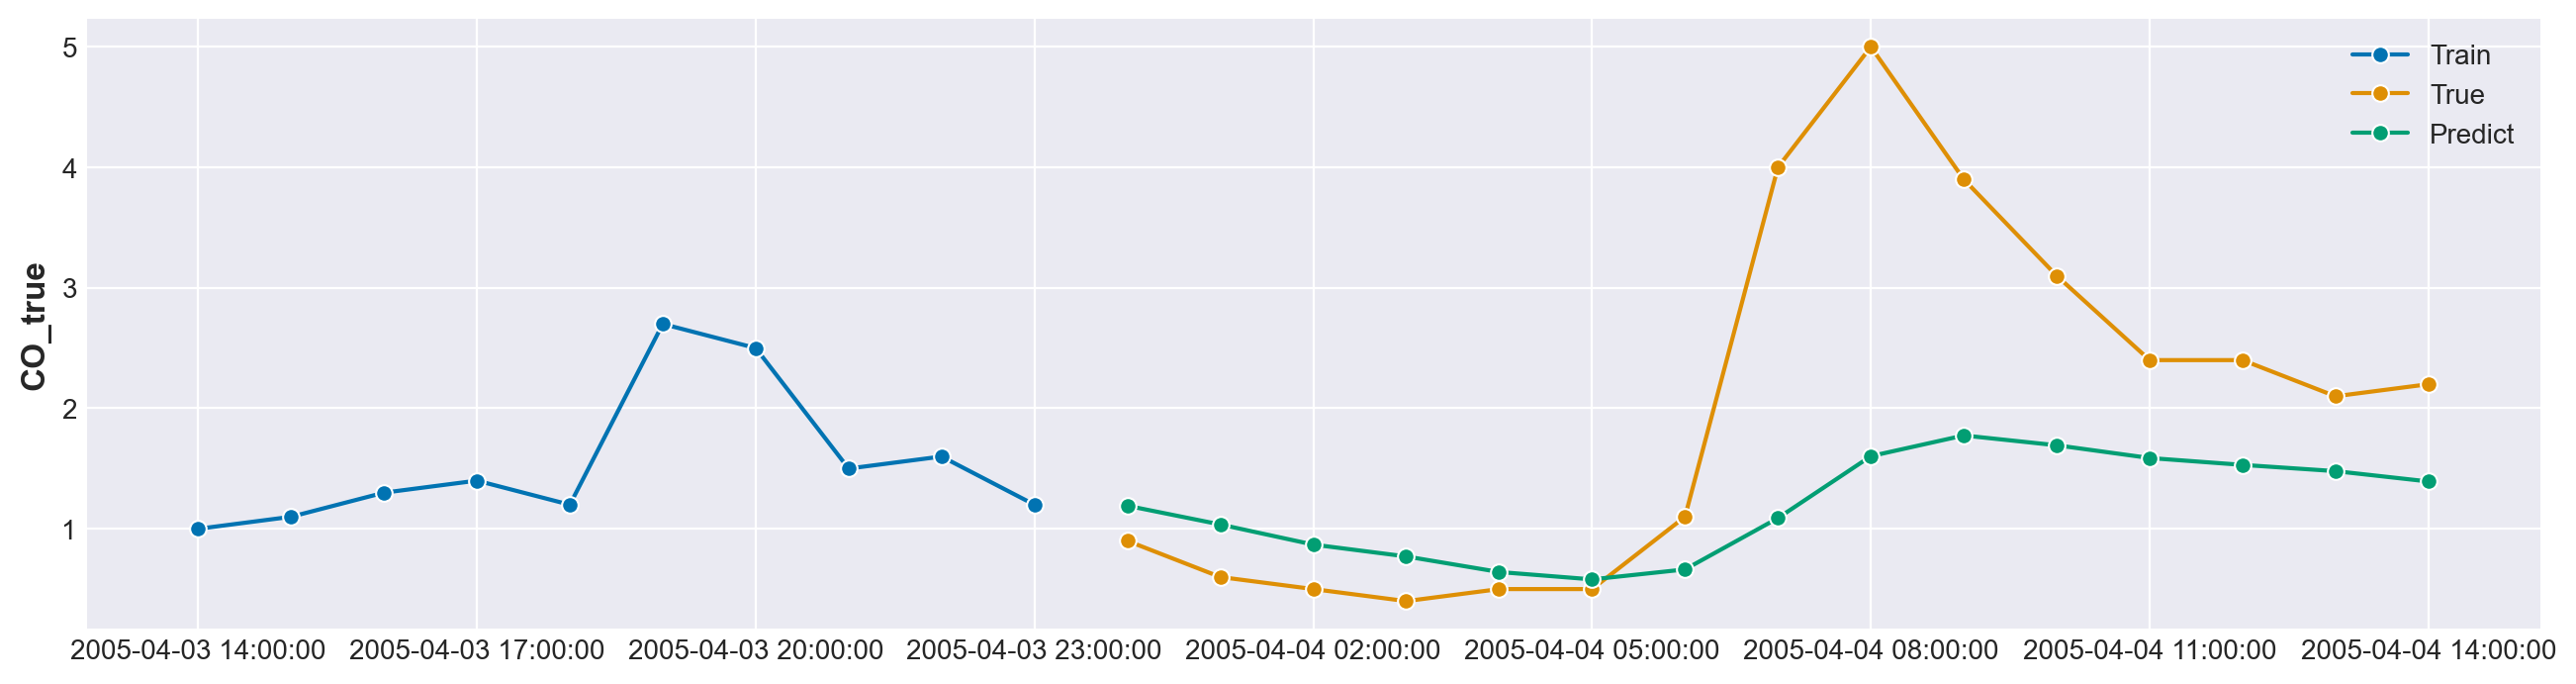

In [14]:
y_predict = gscv.predict(fh=fh, X=x_test)
plot_series(y_train.tail(10), y_test, y_predict, labels=["Train", "True", "Predict"])
y_predict

In [15]:
print(gscv.cv_results_.shape)
gscv.cv_results_.head()

(15, 5)


,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.588596,0.180950,0.868902,{'forecaster__deseasonalizer__model': 'multipl...,12.0
1,0.381344,0.188177,0.958257,{'forecaster__deseasonalizer__model': 'multipl...,4.0
2,0.593508,0.195657,1.108739,{'forecaster__deseasonalizer__model': 'multipl...,13.0
3,0.318299,0.188770,0.897076,{'forecaster__deseasonalizer__model': 'multipl...,1.0
4,0.479842,0.205224,1.136705,{'forecaster__deseasonalizer__model': 'additiv...,9.0


### Backtesting Insample Prediction

In [16]:
from sktime.forecasting.model_evaluation import evaluate

results = evaluate(
    forecaster=gscv.best_forecaster_,
    y=y_train,
    X=x_train,
    cv=cv,
    scoring=MeanAbsolutePercentageError(symmetric=False),
    return_data=True,
)
results

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.395566,0.157128,0.688108,9267,2005-03-31 20:00:00,Date_Time 2004-03-10 18:00:00 2.6 2004-03-1...,Date_Time 2005-03-31 21:00:00 1.0 2005-03-3...,2005-03-31 21:00:00 1.195047 2005-03-31 22:...
1,0.243409,0.141233,0.454091,9282,2005-04-01 11:00:00,Date_Time 2004-03-10 18:00:00 2.6 2004-03-1...,Date_Time 2005-04-01 12:00:00 1.1 2005-04-0...,2005-04-01 12:00:00 1.079469 2005-04-01 13:...
2,0.600883,0.152891,0.505887,9297,2005-04-02 02:00:00,Date_Time 2004-03-10 18:00:00 2.6 2004-03-1...,Date_Time 2005-04-02 03:00:00 0.5 2005-04-0...,2005-04-02 03:00:00 0.569275 2005-04-02 04:...
3,0.553410,0.144968,0.444345,9312,2005-04-02 17:00:00,Date_Time 2004-03-10 18:00:00 2.6 2004-03-1...,Date_Time 2005-04-02 18:00:00 1.1 2005-04-0...,2005-04-02 18:00:00 1.484645 2005-04-02 19:...
4,0.173820,0.141150,0.643056,9327,2005-04-03 08:00:00,Date_Time 2004-03-10 18:00:00 2.6 2004-03-1...,Date_Time 2005-04-03 09:00:00 1.2 2005-04-0...,2005-04-03 09:00:00 0.911441 2005-04-03 10:...


In [27]:
results[['fit_time','pred_time']]

,fit_time,pred_time
0,0.157128,0.688108
1,0.141233,0.454091
2,0.152891,0.505887
3,0.144968,0.444345
4,0.141150,0.643056


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='CO_true'>)

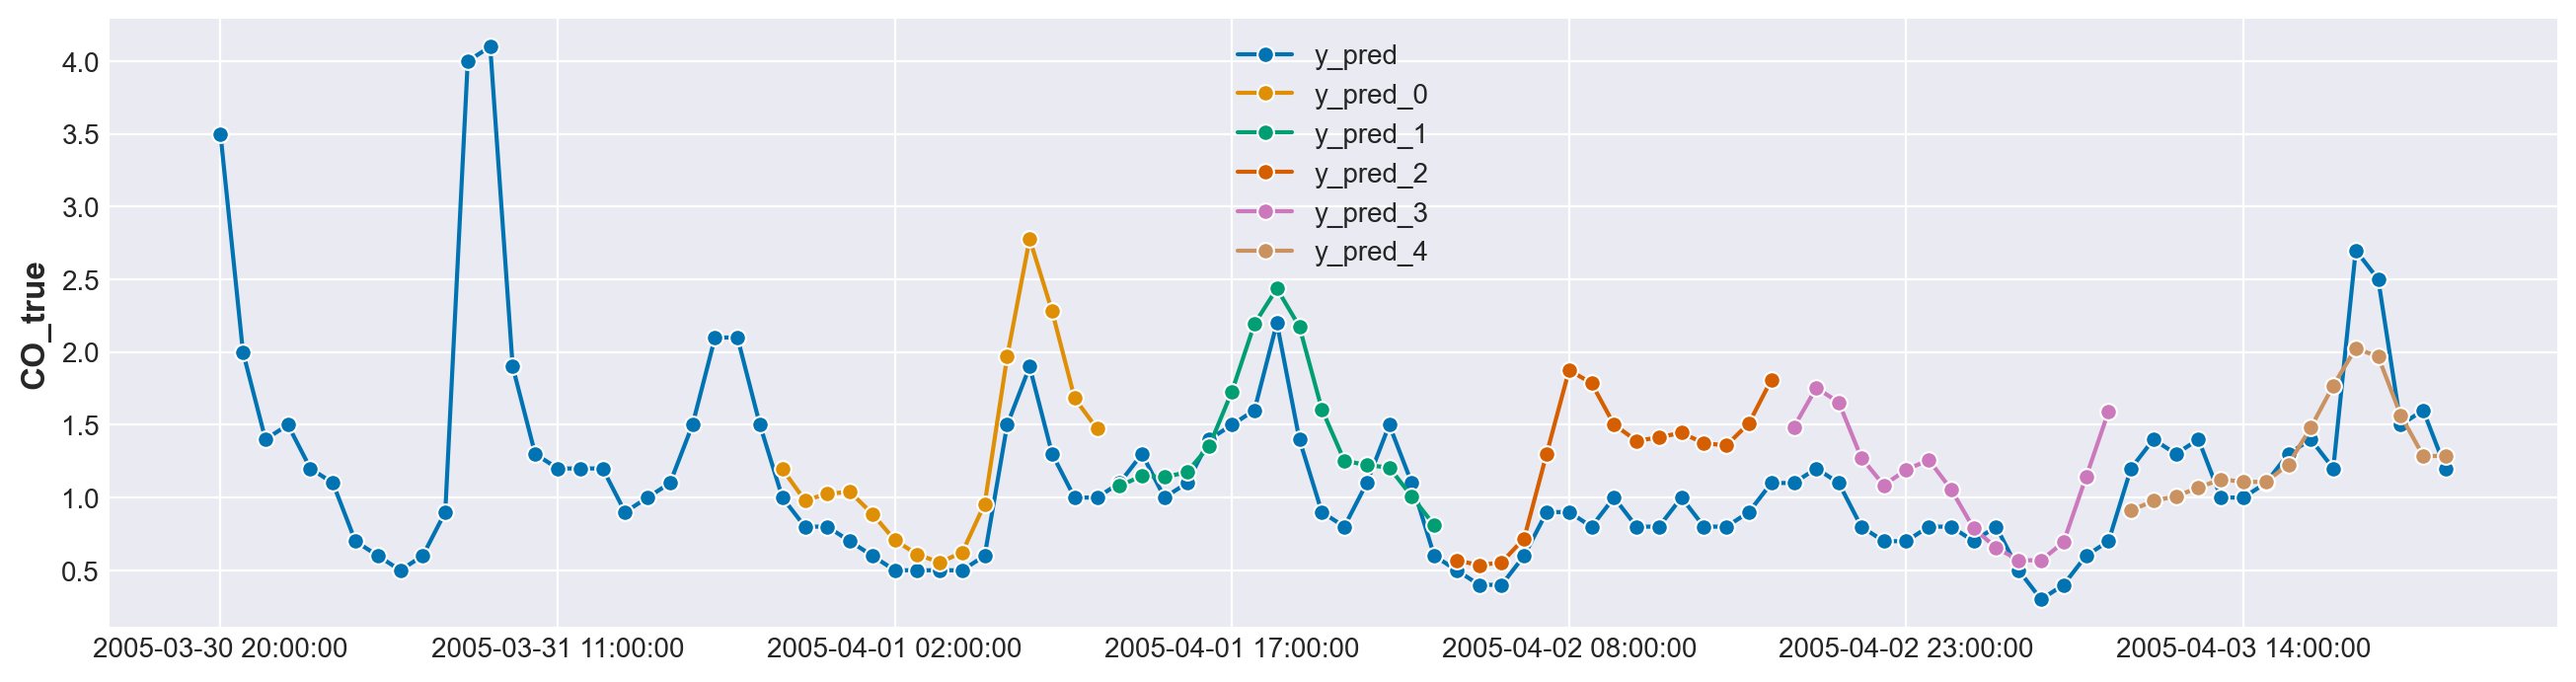

In [17]:
plot_series(
    y_train.tail(100),
    *results["y_pred"].to_list(),
    labels=["y_pred"] + [f"y_pred_{i}" for i in results.index],
)

### Get best model Parameters

In [18]:
gscv.best_forecaster_.get_fitted_params()

{'forecaster': TransformedTargetForecaster(steps=[('imputer_y',
                                     Imputer(method='ffill', random_state=80)),
                                    ('deseasonalizer',
                                     ConditionalDeseasonalizer(model='multiplicative',
                                                               sp=24)),
                                    ('detrender',
                                     Detrender(forecaster=PolynomialTrendForecaster(degree=7))),
                                    ('reducer',
                                     RecursiveTabularRegressionForecaster(estimator=ElasticNet(alpha=0.10590309591477354, fit_intercept=False,
            l1_ratio=0.06509849919039908, random_state=80),
                                                                          pooling='global',
                                                                          window_length=30))]),
 'steps': [('column_Gaurd', ColumnsGuard()),
  ('x_trans

### Train Model Parameter

In [19]:
model_n_features_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__n_features_in"
]
model_fname_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__feature_names_in"
]
model_coeff = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__coef"
]
model_intercept = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__intercept"
]

print(f"model_n_features_in {model_n_features_in}", end="\n\n")
print(f"model_fname_in {model_fname_in}", end="\n\n")
print(f"model_fname_in {model_coeff}", end="\n\n")
print(f"model_fname_in {model_intercept}", end="\n\n")

model_n_features_in 30

model_fname_in ['CO_true_lag_1' 'CO_true_lag_2' 'CO_true_lag_3' 'CO_true_lag_4'
 'CO_true_lag_5' 'CO_true_lag_6' 'CO_true_lag_7' 'CO_true_lag_8'
 'CO_true_lag_9' 'CO_true_lag_10' 'CO_true_lag_11' 'CO_true_lag_12'
 'CO_true_lag_13' 'CO_true_lag_14' 'CO_true_lag_15' 'CO_true_lag_16'
 'CO_true_lag_17' 'CO_true_lag_18' 'CO_true_lag_19' 'CO_true_lag_20'
 'CO_true_lag_21' 'CO_true_lag_22' 'CO_true_lag_23' 'CO_true_lag_24'
 'CO_true_lag_25' 'CO_true_lag_26' 'CO_true_lag_27' 'CO_true_lag_28'
 'CO_true_lag_29' 'CO_true_lag_30']

model_fname_in [ 0.78851777  0.         -0.         -0.          0.          0.00291481
  0.01896534  0.00332704  0.          0.          0.01458657  0.01253053
 -0.         -0.00307578 -0.          0.          0.         -0.
  0.         -0.          0.          0.02056259  0.08879216  0.09851076
 -0.0288071  -0.07680679 -0.01720449 -0.         -0.         -0.        ]

model_fname_in 0.0



### model cutoff

In [20]:
print(gscv.best_forecaster_.cutoff, y_train.index[-1])

DatetimeIndex(['2005-04-03 23:00:00'], dtype='datetime64[ns]', name='Date_Time', freq='H') 2005-04-03 23:00:00


### Model Cloning

In [21]:
from sklearn.base import clone

model = clone(gscv.best_forecaster_).set_params(**gscv.best_params_)

dir(model)

['_X',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rpow__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_anytag_notnone_set',
 '_anytag_notnone_val',
 '_anytagis',
 '_anytagis_then_set',
 '_check_X',
 '_check_X_y',
 '_check_estimators',
 '_check_fh',
 '_check_names',
 '_check_steps',
 '_clone',
 '_clone_flags',
 '_coerce_estimator_tuple',
 '_components',
 '_config',
 '_config_dynamic',
 '_converter_store_y',
 '_cutoff',
 '_dunder_concat',
 '_fh',
 '_fit',
 '_get_class_flag',
 '_get_class_flags',
 '_get_estimator_list',
 '_get_estimator_names',
 '_get_estimator_tuples',
 '_get_fitted_params',
 '_get_fitted_params_default',


### Model saving 

In [22]:
# gscv.best_forecaster_.save("../results/elastic_net")

import joblib

joblib.dump(gscv.best_forecaster_, "../results/elastic_net.pkl")

FileNotFoundError: [Errno 2] No such file or directory: '../results/elastic_net.pkl'

### Features importance

In [ ]:
pd.DataFrame(model_coeff, index=model_fname_in, columns=["Coeff"]).plot(
    kind="barh", alpha=0.75
)

In [ ]:
class BaseModel:
    def __init__(self) -> None:
        pass
    
    @classmethod
    @property
    def description(cls):
        return cls._description

        
class LinearModel(BaseModel):
    _description: str = "Liner Model Conditional Deseasonalizer Detrender"
        
    def __init__(self):
        super().__init__()

print(LinearModel.description)        

In [ ]:
xy().name

In [ ]:
from enum import IntEnum
import os
from dataclasses import dataclass


class SchudulerState(IntEnum):

    Init = 0
    Sety = 1
    SetX = 1
    SetFH = 1
    ExtractingStat = 2
    SelectingModel = 3
    TunningModel = 4
    SavingModel = 5

In [ ]:
SchudulerState.SetX > SchudulerState.Init

In [ ]:
all([None,None,None])

In [ ]:
class Decorator(object):
    
    def __init__(self, decoratee_enclosing_class):
        self.decoratee_enclosing_class = decoratee_enclosing_class
        
    def __call__(self, original_func):
        def new_function(*args, **kwargs):
            print('decorating function in ', self.decoratee_enclosing_class)
            original_func(*args, **kwargs)
        return new_function

In [ ]:
class Bar(object):
    @Decorator('Bar')
    def foo(self):
        print('in foo')

In [ ]:
print('before instantiating Bar()')
b = Bar()
print('calling b.foo()')
b.foo()